# Training model

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import gc
import torch
import torchvision
from petastorm import TransformSpec
from pyspark.sql import SparkSession
from functools import partial 
from torch import nn
from sklearn import preprocessing
from torch.utils.data import DataLoader
from torchdata.datapipes.iter import FileLister
import torcharrow.dtypes as dt
from petastorm.spark import SparkDatasetConverter, make_spark_converter
from torchvision import transforms
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as data
import pyarrow.feather as feather

/data/tools_tese/pytorch-env/lib/python3.10/site-packages/petastorm/spark/spark_dataset_converter.py:28: FutureWarning: pyarrow.LocalFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
  from pyarrow import LocalFileSystem


In [2]:
spark = SparkSession \
    .builder \
    .appName("Data_Import") \
    .config("spark.memory.offHeap.enabled","true") \
    .config("spark.driver.cores","4") \
    .config("spark.driver.maxResultSize","4g") \
    .config("spark.memory.offHeap.size","4g") \
    .config("spark.driver.memory", "4g")\
    .config("spark.executor.memory","4g")\
    .getOrCreate()


23/07/10 20:42:23 WARN Utils: Your hostname, saltedcookie-PC resolves to a loopback address: 127.0.1.1; using 192.168.1.199 instead (on interface enp42s0)
23/07/10 20:42:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/10 20:42:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/07/10 20:42:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev)
print(dev)

cuda:0


## Import data for modeling

In [4]:
# IMPORT DATA
merged_data = pd.read_feather("/data/dados_tese/feather/arrivals-trends-exchange-inflation.feather")

In [5]:
merged_data

,date,Portugal_shopping_norm,Portugal_airport_norm,Portugal_travel_guide_norm,Portugal_travel_map_norm,Portugal_travel_norm,Portugal_tickets_norm,Portugal_map_norm,Portugal_flights_norm,Portugal_hotels_norm,...,EURINR_Open,EURBRL_Open,EURGBP_Open,EURJPY_Open,EURHKD_Open,EURCNY_Open,EURCAD_Open,EURAUD_Open,EURUSD_Open,inflation
0,2016-01-01,0.0,51.39,0.00,32.76,55.72,22.13,0.00,54.08,59.50,...,71.814003,4.289100,0.736730,130.612000,8.414900,7.022800,1.509300,1.493330,1.085906,700.000000
1,2016-01-02,0.0,44.87,0.00,0.00,48.03,21.67,0.00,52.23,69.10,...,71.630150,4.241945,0.736623,131.239822,8.419034,6.990259,1.504893,1.479560,1.086726,711.217285
2,2016-01-03,0.0,55.52,0.00,11.44,55.11,20.29,0.00,50.23,71.80,...,71.630150,4.244245,0.736506,131.219162,8.417400,6.990259,1.503647,1.478283,1.086593,721.571716
3,2016-01-04,0.0,51.61,0.00,0.00,55.72,20.75,0.00,54.69,73.00,...,71.814003,4.296000,0.736380,130.550003,8.410000,7.022800,1.505560,1.489500,1.085505,731.063293
4,2016-01-05,0.0,54.22,0.00,0.00,58.35,15.00,0.00,52.85,65.80,...,72.003998,4.369400,0.735650,129.298996,8.389590,7.062600,1.508430,1.506730,1.082603,739.692017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2019-12-27,0.0,59.19,16.25,0.00,63.18,22.75,28.81,88.90,64.92,...,78.959000,4.524100,0.853700,121.714996,8.644270,7.757900,1.455190,1.597590,1.110124,398.981873
1457,2019-12-28,0.0,58.88,0.00,16.40,57.10,22.98,29.56,91.37,48.96,...,78.690544,4.514729,0.853223,122.107224,8.658854,7.769006,1.454865,1.596544,1.112064,400.000000
1458,2019-12-29,0.0,74.38,29.90,0.00,78.00,22.06,31.06,95.68,71.00,...,78.263741,4.503146,0.853681,122.428619,8.684548,7.791493,1.458841,1.599636,1.115272,400.509064
1459,2019-12-30,0.0,65.70,0.00,0.00,67.74,28.73,27.50,86.44,59.22,...,78.587402,4.497200,0.854060,122.401001,8.707010,7.808400,1.461830,1.600940,1.118155,400.509064


In [6]:
merged_data.describe()

,Portugal_shopping_norm,Portugal_airport_norm,Portugal_travel_guide_norm,Portugal_travel_map_norm,Portugal_travel_norm,Portugal_tickets_norm,Portugal_map_norm,Portugal_flights_norm,Portugal_hotels_norm,Portugal_weather_norm,...,EURINR_Open,EURBRL_Open,EURGBP_Open,EURJPY_Open,EURHKD_Open,EURCNY_Open,EURCAD_Open,EURAUD_Open,EURUSD_Open,inflation
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,...,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,25.813203,65.528371,7.792731,8.710281,64.634682,25.947871,31.272088,66.028446,63.463155,21.088282,...,76.630241,4.039996,0.864238,124.854317,8.855295,7.598224,1.486614,1.538226,1.134402,915.117188
std,29.890448,13.002794,15.814064,13.309998,11.780598,8.647741,15.659355,15.054652,13.858157,19.527202,...,3.560833,0.401241,0.037814,5.830298,0.370933,0.232264,0.042521,0.069375,0.044588,634.902283
min,0.000000,28.000000,0.000000,0.000000,29.000000,11.000000,0.000000,27.000000,24.000000,0.000000,...,67.026779,3.196986,0.732500,110.358055,8.068290,6.902716,1.379490,1.370720,1.039393,-739.917480
25%,0.000000,55.600000,0.000000,0.000000,56.930000,20.120000,26.560000,54.080000,56.890000,0.000000,...,74.275002,3.690100,0.853180,120.837418,8.638820,7.389500,1.460010,1.483600,1.107984,539.121460
50%,0.000000,66.780000,0.000000,0.000000,66.290000,26.040000,37.890000,65.640000,66.830000,24.440000,...,76.674004,4.076900,0.875330,124.709999,8.799820,7.658500,1.486915,1.553210,1.127904,803.808655
75%,57.000000,75.500000,7.360000,14.000000,72.570000,30.360000,41.720000,78.670000,72.820000,39.160000,...,79.252792,4.374300,0.889077,129.615997,9.114850,7.794500,1.511850,1.597810,1.164077,1386.487183
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,85.744003,4.938700,0.932120,138.180008,9.815446,8.043100,1.613690,1.666119,1.255372,2411.020508


In [7]:
len(merged_data.columns)

27

In [8]:
merged_data.columns

Index(['date', 'Portugal_shopping_norm', 'Portugal_airport_norm',
       'Portugal_travel_guide_norm', 'Portugal_travel_map_norm',
       'Portugal_travel_norm', 'Portugal_tickets_norm', 'Portugal_map_norm',
       'Portugal_flights_norm', 'Portugal_hotels_norm',
       'Portugal_weather_norm', 'Portugal_attractions_norm',
       'Portugal_food_norm', 'arrivals', 'EURKRW_Open', 'EURCHF_Open',
       'EURRUB_Open', 'EURINR_Open', 'EURBRL_Open', 'EURGBP_Open',
       'EURJPY_Open', 'EURHKD_Open', 'EURCNY_Open', 'EURCAD_Open',
       'EURAUD_Open', 'EURUSD_Open', 'inflation'],
      dtype='object')

## Normalize

In [30]:
merged_data.columns

Index(['date', 'Portugal_shopping_norm', 'Portugal_airport_norm',
       'Portugal_travel_guide_norm', 'Portugal_travel_map_norm',
       'Portugal_travel_norm', 'Portugal_tickets_norm', 'Portugal_map_norm',
       'Portugal_flights_norm', 'Portugal_hotels_norm',
       'Portugal_weather_norm', 'Portugal_attractions_norm',
       'Portugal_food_norm', 'arrivals', 'EURKRW_Open', 'EURCHF_Open',
       'EURRUB_Open', 'EURINR_Open', 'EURBRL_Open', 'EURGBP_Open',
       'EURJPY_Open', 'EURHKD_Open', 'EURCNY_Open', 'EURCAD_Open',
       'EURAUD_Open', 'EURUSD_Open', 'inflation'],
      dtype='object')

In [37]:
# NORMALIZE DATA
timeseries_arrivals = merged_data[["arrivals"]].values.astype('float32')
timeseries_features = merged_data[[column for column in merged_data.columns if "norm" in column or column == "arrivals"]].values.astype('float32')

feature_columns = merged_data[[column for column in merged_data.columns if "norm" in column]].columns

min_max_scaler = preprocessing.MinMaxScaler()
timeseries_arrivals = min_max_scaler.fit_transform(timeseries_arrivals)
timeseries_features = min_max_scaler.fit_transform(timeseries_features)

## Modeling

In [36]:
# Hyper Parameters
hidden_size = 100
num_layers = 1
learn_rate = 1e-6
percent_of_train = 0.70
batch_size=2**4          #you can change but use 2**x
lookback = 90
max_weaken = 5
future_step = 30

In [20]:
def create_dataset_feature(dataset, lookback):
    X = []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        X.append(feature)
    return torch.tensor(X).to(device)

def create_dataset_target(dataset, lookback):
    y = []
    for i in range(len(dataset)-lookback):
        target = dataset[i+1:i+lookback+1]
        y.append(target)
    return torch.tensor(y).to(device)

def create_dataset(feature_dataset, target_dataset, lookback, future_step):
    X, y = [], []
    for i in range(len(feature_dataset)-lookback):
        if i+future_step < len(target_dataset) and i+lookback+future_step < len(target_dataset):
            feature = feature_dataset[i:i+lookback]
            target = target_dataset[i+future_step:i+lookback+future_step]
            X.append(feature)
            y.append(target)
    return torch.tensor(X).to(device), torch.tensor(y).to(device)

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=len(timeseries_features[0]), hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x


In [21]:
# TRAIN/TEST SPLIT
train_size = int(len(timeseries_arrivals) * percent_of_train)
test_size = len(timeseries_arrivals) - train_size
train_feature, test_feature = timeseries_features[:train_size], timeseries_features[train_size:]
train_target, test_target = timeseries_arrivals[:train_size], timeseries_arrivals[train_size:]

In [22]:
# MODELING
X_train, y_train = create_dataset(train_feature, train_target, lookback=lookback, future_step = future_step)
X_test, y_test = create_dataset(test_feature, test_target, lookback=lookback, future_step = future_step)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

model = AirModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=learn_rate)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)

iterator = -1

torch.Size([902, 90, 13]) torch.Size([902, 90, 1])
torch.Size([319, 90, 13]) torch.Size([319, 90, 1])


In [23]:
weaken_counter = 0
best_test_rmse = 1
prev_test_rmse = 1

In [24]:
n_epochs = 2000
for epoch in range(n_epochs):
    iterator += 1
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred.cpu(), y_train.cpu()))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred.cpu(), y_test.cpu()))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (iterator, train_rmse, test_rmse))
    
    # Testing and saving the best model
    if test_rmse < best_test_rmse:
        best_test_rmse = test_rmse
        weaken_counter = 0
        best_model = model
    else: # Stop condition (if the prediction strength weakens "max_weaken" times, the algorithm stops)
        if test_rmse > prev_test_rmse:
            weaken_counter += 1
            print("Worse")
        if weaken_counter >= max_weaken:
            print(f"Limit reached, best_test_rmse={best_test_rmse}")
            model = best_model
            break
    prev_test_rmse = test_rmse
        

Epoch 0: train RMSE 0.5479, test RMSE 0.6489
Epoch 10: train RMSE 0.5296, test RMSE 0.6296
Epoch 20: train RMSE 0.5114, test RMSE 0.6104
Epoch 30: train RMSE 0.4929, test RMSE 0.5908
Epoch 40: train RMSE 0.4740, test RMSE 0.5707
Epoch 50: train RMSE 0.4545, test RMSE 0.5500
Epoch 60: train RMSE 0.4342, test RMSE 0.5282
Epoch 70: train RMSE 0.4130, test RMSE 0.5053
Epoch 80: train RMSE 0.3908, test RMSE 0.4811
Epoch 90: train RMSE 0.3672, test RMSE 0.4552
Epoch 100: train RMSE 0.3423, test RMSE 0.4275
Epoch 110: train RMSE 0.3158, test RMSE 0.3976
Epoch 120: train RMSE 0.2876, test RMSE 0.3653
Epoch 130: train RMSE 0.2580, test RMSE 0.3306
Epoch 140: train RMSE 0.2275, test RMSE 0.2940
Epoch 150: train RMSE 0.1982, test RMSE 0.2569
Epoch 160: train RMSE 0.1737, test RMSE 0.2228
Epoch 170: train RMSE 0.1581, test RMSE 0.1969
Epoch 180: train RMSE 0.1516, test RMSE 0.1821
Epoch 190: train RMSE 0.1494, test RMSE 0.1757
Epoch 200: train RMSE 0.1480, test RMSE 0.1727
Epoch 210: train RMSE 0.

In [31]:
# Preparing values after model training

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries_arrivals) * np.nan
    train_plot[lookback+future_step:train_size] = best_model(X_train).cpu()[:, -1, :]
    
    # shift validation predictions for plotting
    # validation_plot = np.ones_like(timeseries_arrivals) * np.nan
    # validation_plot[train_size+lookback+future_step:train_size+val_size] = best_model(X_validation).cpu()[:, -1, :]
    
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries_arrivals) * np.nan
    # test_plot[train_size+lookback+val_size+future_step:len(timeseries_arrivals)] = best_model(X_test).cpu()[:, -1, :]
    test_plot[train_size+lookback+future_step:len(timeseries_arrivals)] = best_model(X_test).cpu()[:, -1, :]

# Plot

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

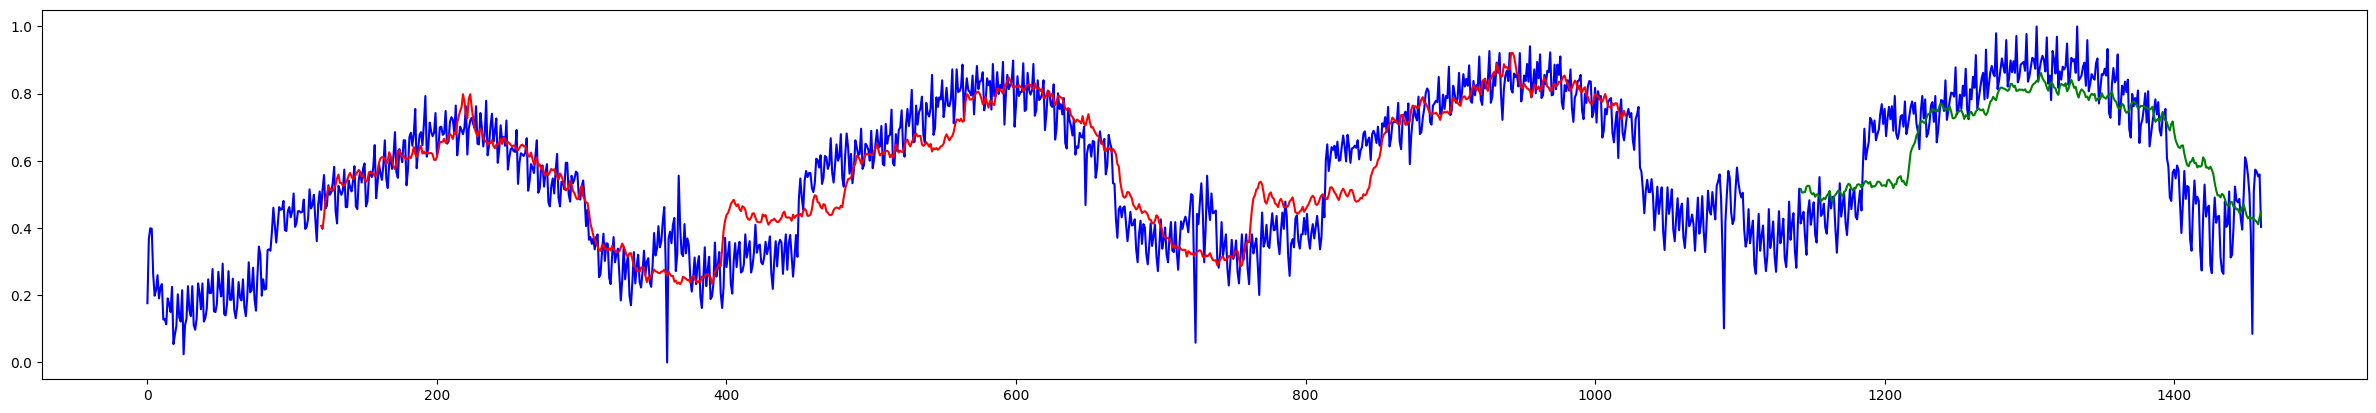

In [33]:
#target = pd.read_pickle("/data/models/target.pkl")
#train_plot = pd.read_pickle("/data/models/train.pkl")
#test_plot = pd.read_pickle("/data/models/test.pkl")

# plot
plt.figure().set_figwidth(30)
plt.plot(timeseries_arrivals, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

# Save model

In [ ]:
mypath = "/data/models/pytorch_models/"
nums = [int(f.replace("model", "")) for f in listdir(mypath) if "model" in f]
biggest = nums[0]
for num in nums:
    if num > biggest:
        biggest = num

PATH = f"{mypath}model{biggest+1}/"

### Save

In [ ]:
filename = PATH + "hyperparameters.txt"

os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, "w") as f:
    f.write(f'''hidden_size = {hidden_size}
num_layers = {num_layers}
learn_rate = {learn_rate}
percent_of_train = {percent_of_train}
batch_size = {batch_size}
lookback = {lookback}
epochs = {iterator}
features = {feature_columns}
target = arrivals
best_test_rmse={best_test_rmse}''')

torch.save(model.state_dict(), PATH + "model.pkl")

# Load model

In [ ]:
model = AirModel()
model.load_state_dict(torch.load("/data/models/pytorch_models/model1/model.pkl"))
model.eval()

AirModel(
  (lstm): LSTM(11, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
# Parameters
hidden_size = 50
num_layers = 1
learn_rate = 2e-6
percent_of_train = 0.70
batch_size=2**4          #you can change but use 2**x
lookback = 90

In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries_arrivals) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train).cpu()[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries_arrivals) * np.nan
    test_plot[train_size+lookback:len(timeseries_arrivals)] = model(X_test).cpu()[:, -1, :]

# Save results

In [ ]:
results = pd.DataFrame(test_plot)

results["date"] = merged_data["date"]
results = results.dropna()
results = results.rename(columns={0: "value"})
results = results[["date", "value"]]

In [ ]:
results

,date,value
1112,2019-01-17,0.322280
1113,2019-01-18,0.334275
1114,2019-01-19,0.346426
1115,2019-01-20,0.326535
1116,2019-01-21,0.365658
...,...,...
1456,2019-12-27,0.474011
1457,2019-12-28,0.418302
1458,2019-12-29,0.379918
1459,2019-12-30,0.491384


In [ ]:
feather.write_feather(results, "/data/dados_tese/feather/results_test.feather")